In [49]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [50]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [51]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [225]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [225]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [225]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [225, 79]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]

Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917524648060734
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.485070182320798)]
Initial energy: -6.123105625156509
Optimizing energy with indices [225, 79, 210, 201]...
Starting point: [np.float64(0.7854083594345374), np.float64(0.7854119606462776), np.float64(0.1224890566135788), np.float64(0.0)]

Current energy: -6.327276154047746
(change of -0.204170528891237)
Current ansatz: [225, 79, 210, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240932718655653
Operator(s) added to ansatz: [78]
Gradients: [np.float64(-2.089515135775932)]
Initial energy: -6.327276154047746
Optimizing energy with indices [225, 79, 210, 201, 78]...
Starting point: [np.float64(0.7854062333606995), np.float64(0.7854112677643331), np.float64(0.16356354211858012), np.float64(0.16356761613212406), np.float64(0.0)]

Current energy: -6.464101614778482
(change of -0.1368254607307362)
Current ansatz: [2

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0003086750599346189

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240932718655653 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819706
(change of -0.20417052920206658)
Current ansatz: [244, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531788
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.089492926734881)]
Initial energy: -6.327276154819706
Optimizing energy with indices [244, 79, 228, 198, 135]...
Starting point: [np.float64(0.7853981646905418), np.float64(0.7853981643651434), np.float64(0.16357019740836648), np.float64(-0.1635696366828733), np.float64(0.0)]

Current energy: -6.464101615132657
(change of -0.13682546031295129)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775814
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710484682805)]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 198]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.1224892796166995), np.float64(0.0)]

Current energy: -6.327276154764737
(change of -0.20417052920225576)
Current ansatz: [228, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258122057
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.089492926730207)]
Initial energy: -6.327276154764737
Optimizing energy with indices [228, 79, 228, 198, 135]...
Starting point: [np.float64(-0.7853947065772768), np.float64(0.7853982468607503), np.float64(0.16357019741060347), np.float64(-0.16356963668333527), np.float64(0.0)]

Current energy: -6.464101615080612
(change of -0.13682546031587428)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.9999999994172235
(change of -1.3737154597822574)
Current ansatz: [210, 244, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958970181073
Operator(s) added to ansatz: [198]
Gradients: [np.float64(1.9999999998057416)]
Initial energy: -5.9999999994172235
Optimizing energy with indices [210, 244, 79, 198]...
Starting point: [np.float64(9.855378898648838e-06), np.float64(0.7853981714335069), np.float64(0.7853981407341537), np.float64(0.0)]

Current energy: -6.12310562503605
(change of -0.12310562561882676)
Current ansatz: [210, 244, 79, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200545991
Operator(s) added to ansatz: [141]
Gradients: [np.float64(2.4850710482551506)]
Initial energy: -6.12310562503605
Optimizing energy with indices [210, 244, 79, 198, 141]...
Starting point: [np.float64(9.70962763559127

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [180]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [180]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [180]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000003)]
Initial energy: -4.236067977499796
Optimizing energy with indices [180, 79]...
Starting point: [np.float64(0.553574358897045), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998181
(change of -1.763932022498385)
Current ansatz: [180, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140561
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999999944194)]
Initial energy: -5.999999999998181
Optimizing energy with indices [180, 79, 228]...
Starting point: [np.float64(0.7853985607314248), np.float64(0.7853989420959429), np.float64(0.0)]

Current energy: -6.123105625610648
(change of -0.1231056256124674)
Current ansatz: [180, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752214895574
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868947)]
Initial energy: -6.123105625610648
Optimizing energy with indices [180, 79, 228, 210]...
Starting point: [np.float64(0.7853983869831838), np.float64(0.7853991695302298), np.float64(0.1224886

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916426871495)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 198]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.464101615072771
(change of -0.1368254602527843)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474305875)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 198]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.32727615482008
(change of -0.20417052920242895)
Current ansatz: [244, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963610610418
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894920221535056)]
Initial energy: -6.32727615482008
Optimizing energy with indices [244, 79, 225, 198, 210]...
Starting point: [np.float64(0.7853981493735948), np.float64(0.7853981777037257), np.float64(-0.16357026021874255), np.float64(-0.16356987308330864), np.float64(0.0)]

Current energy: -6.464101615050827
(change of -0.13682546023074682)
Current ansatz: [244, 79, 225, 198, 210]
Performing final convergence check...
Total gradient norm: 0.00014811055823501704

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963610610418 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating l

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916426871495)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 198]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.464101615072771
(change of -0.1368254602527843)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200769645
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048168968)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 26, 216, 225]...
Starting point: [np.float64(0.7853981651172142), np.float64(0.7853981644855549), np.float64(-0.1224892795340391), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920233658)
Current ansatz: [244, 26, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640432122835
Operator(s) added to ansatz: [54]
Gradients: [np.float64(-2.0894916422607617)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 26, 216, 225, 54]...
Starting point: [np.float64(0.7853981637617629), np.float64(0.7853981645760632), np.float64(-0.1635702865969174), np.float64(-0.16356997236320656), np.float64(0.0)]

Current energy: -6.4641016150721375
(change of -0.13682546025215014)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619964306
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710475410684)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 210, 201]...
Starting point: [np.float64(0.7853981908695737), np.float64(0.7853981903042655), np.float64(0.12248927937223411), np.float64(0.0)]

Current energy: -6.327276154820032
(change of -0.204170529202381)
Current ansatz: [244, 79, 210, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963744097293
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.0894919049611254)]
Initial energy: -6.327276154820032
Optimizing energy with indices [244, 79, 210, 201, 180]...
Starting point: [np.float64(0.7853982036078874), np.float64(0.7853982533205262), np.float64(0.16357026836397243), np.float64(0.1635699037121557), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101614752832
(change of -0.13682545993280026)
Current ansatz: [244, 79, 210, 201, 180]
Performing final convergence check...
Total gradient norm: 0.00023661536974689252

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963744097293 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.00000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000027)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 225]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617631
(change of -0.12310562561761706)
Current ansatz: [244, 26, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440658
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.48507104742827)]
Initial energy: -6.123105625617631
Optimizing energy with indices [244, 26, 225, 147]...
Starting point: [np.float64(0.7853981632980831), np.float64(0.78539816328158), np.float64(-0.12248927

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013506060776882314

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041893821 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819706
(change of -0.20417052920206658)
Current ansatz: [244, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531788
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734881)]
Initial energy: -6.327276154819706
Optimizing energy with indices [244, 79, 228, 198, 210]...
Starting point: [np.float64(0.7853981646905418), np.float64(0.7853981643651434), np.float64(0.16357019740836648), np.float64(-0.1635696366828733), np.float64(0.0)]

Current energy: -6.464101615132637
(change of -0.13682546031293086)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.763932022498393)
Current ansatz: [228, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897114057
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.999999999994421)]
Initial energy: -5.999999999998188
Optimizing energy with indices [228, 31, 228]...
Starting point: [np.float64(-0.7853985607314264), np.float64(-0.7853989420959467), np.float64(0.0)]

Current energy: -6.123105625610651
(change of -0.12310562561246297)
Current ansatz: [228, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955701
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850687898689223)]
Initial energy: -6.123105625610651
Optimizing energy with indices [228, 31, 228, 198]...
Starting point: [np.float64(-0.7853983869831787), np.float64(-0.7853991695302327), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 108]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 7.742895848061765e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531789 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 147]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819707
(change of -0.2041705292020648)
Current ansatz: [241, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409625805317495
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894929267349442)]
Initial energy: -6.327276154819707
Optimizing energy with indices [241, 79, 228, 147, 210]...
Starting point: [np.float64(-0.7853981622864769), np.float64(0.7853981648066234), np.float64(0.1635701974083699), np.float64(-0.16356963668285893), np.float64(0.0)]

Current energy: -6.464101615134799
(change of -0.13682546031509268)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 2.784121640913492e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409625805317495 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 79]...
Starting point: [np.float64(-0.5535743588970451), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917529967152875
Operator(s) added to ansatz: [99]
Gradients: [np.float64(-2.485073147276325)]
Initial energy: -6.12310562560079
Optimizing energy with indices [228, 79, 210, 99]...
Starting point: [np.float64(-0.7853960818962284), np.float64(0.7853979330782069), np.float64(0.12248982046199174), np.float64(0.0)]

Current energy: -6.327276154643472
(change of -0.20417052904268207)
Current ansatz: [228, 79, 210, 99]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962167633992
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.089493711801505)]
Initial energy: -6.327276154643472
Optimizing energy with indices [228, 79, 210, 99, 225]...
Starting point: [np.float64(-0.7853903259924866), np.float64(0.7853926860734026), np.float64(0.16357025229428723), np.float64(0.16356946180458065), np.float64(0.0)]

Current energy: -6.464101614721127
(change of -0.13682546007765506)
Current ansatz: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0002417535833276563

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962167633992 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 26]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440658
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.48507104742827)]
Initial energy: -6.123105625617631
Optimizing energy with indices [244, 26, 225, 147]...
Starting point: [np.float64(0.7853981632980831), np.float64(0.78539816328158), np.float64(-0.12248927934316764), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548199945
(change of -0.20417052920236323)
Current ansatz: [244, 26, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041893821
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089491643417097)]
Initial energy: -6.3272761548199945
Optimizing energy with indices [244, 26, 225, 147, 210]...
Starting point: [np.float64(0.7853981619384316), np.float64(0.785398165460987), np.float64(-0.16357028651624184), np.float64(-0.16356997206090712), np.float64(0.0)]

Current energy: -6.464101615072618
(change of -0.13682546025262354)
Current ansatz: [244, 26, 225, 147, 210]
Performing final convergence check...
Total gradient norm: 0.0001351540793384578

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041893821 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002084338061577

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 26]...
Starting point: [np.float64(-0.5535743588970441), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441738
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.48507104742887)]
Initial energy: -6.123105625617638
Optimizing energy with indices [241, 26, 228, 135]...
Starting point: [np.float64(-0.7853981634447681), np.float64(0.7853981634524064), np.float64(0.12248927934332132), np.float64(0.0)]

Current energy: -6.32727615481999
(change of -0.20417052920235168)
Current ansatz: [241, 26, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041695878
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.089491643590916)]
Initial energy: -6.32727615481999
Optimizing energy with indices [241, 26, 228, 135, 147]...
Starting point: [np.float64(-0.7853981644211435), np.float64(0.7853981626034209), np.float64(0.16357028650417196), np.float64(0.16356997201548157), np.float64(0.0)]

Current energy: -6.464101615072494
(change of -0.13682546025250364)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013525873417341962

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041695878 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 31]...
Starting point: [np.float64(-0.5535743588970451), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955701
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850687898689223)]
Initial energy: -6.123105625610651
Optimizing energy with indices [228, 31, 228, 198]...
Starting point: [np.float64(-0.7853983869831787), np.float64(-0.7853991695302327), np.float64(0.12248869758309996), np.float64(0.0)]

Current energy: -6.327276154816358
(change of -0.20417052920570722)
Current ansatz: [228, 31, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962567146087
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894929485623472)]
Initial energy: -6.327276154816358
Optimizing energy with indices [228, 31, 228, 198, 210]...
Starting point: [np.float64(-0.7853984388738867), np.float64(-0.785399159170192), np.float64(0.16357019849086207), np.float64(-0.16356963170331268), np.float64(0.0)]

Current energy: -6.464101615132119
(change of -0.1368254603157606)
Current 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917518430081312
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485066714324805)]
Initial energy: -6.1231056252069065
Optimizing energy with indices [228, 79, 216, 225]...
Starting point: [np.float64(-0.7853879048615375), np.float64(0.7853901599313474), np.float64(-0.12248816317024809), np.float64(0.0)]

Current energy: -6.327276154818593
(change of -0.20417052961168647)
Current ansatz: [228, 79, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964791886525
Operator(s) added to ansatz: [156]
Gradients: [np.float64(-2.089491649572314)]
Initial energy: -6.327276154818593
Optimizing energy with indices [228, 79, 216, 225, 156]...
Starting point: [np.float64(-0.7853981629684735), np.float64(0.7853982668128193), np.float64(-0.163570458016993), np.float64(-0.16357001840315244), np.float64(0.0)]

Current energy: -6.464101615072779
(change of -0.13682546025418585)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526155292668
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071021848481)]
Initial energy: -6.123105625475232
Optimizing energy with indices [228, 74, 216, 225]...
Starting point: [np.float64(-0.7854038547368931), np.float64(-0.7854037258580634), np.float64(-0.12248927291337362), np.float64(0.0)]

Current energy: -6.327276154553896
(change of -0.20417052907866395)
Current ansatz: [228, 74, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240988004503404
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.0894919025205727)]
Initial energy: -6.327276154553896
Optimizing energy with indices [228, 74, 216, 225, 201]...
Starting point: [np.float64(-0.7853981585499862), np.float64(-0.7853980752466324), np.float64(-0.16357577691030825), np.float64(-0.16357144060194082), np.float64(0.0)]

Current energy: -6.464101615040675
(change of -0.13682546048677846)
Curre

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00015588364229659842

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240988004503404 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 74]...
Starting point: [np.float64(-0.5535743588970451), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752214895575
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.4850687898620225)]
Initial energy: -6.12310562561065
Optimizing energy with indices [228, 74, 228, 120]...
Starting point: [np.float64(-0.7853983869831829), np.float64(-0.7853991695302484), np.float64(0.12248869758310722), np.float64(0.0)]

Current energy: -6.327276154815321
(change of -0.20417052920467071)
Current ansatz: [228, 74, 228, 120]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964171650655
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491644846868)]
Initial energy: -6.327276154815321
Optimizing energy with indices [228, 74, 228, 120, 198]...
Starting point: [np.float64(-0.7853982921525917), np.float64(-0.7853991637528411), np.float64(0.1635703162426325), np.float64(0.16356998000606945), np.float64(0.0)]

Current energy: -6.46410161439221
(change of -0.1368254595768894)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775825
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710484682836)]
Initial energy: -6.12310562556249
Optimizing energy with indices [225, 74, 228, 198]...
Starting point: [np.float64(0.7853947065772676), np.float64(-0.7853985308794365), np.float64(0.1224892796166996), np.float64(0.0)]

Current energy: -6.327276154764744
(change of -0.20417052920225398)
Current ansatz: [225, 74, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962581220504
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.089492926690323)]
Initial energy: -6.327276154764744
Optimizing energy with indices [225, 74, 228, 198, 120]...
Starting point: [np.float64(0.7853947065771448), np.float64(-0.7853982468607457), np.float64(0.16357019741059903), np.float64(-0.1635696366833181), np.float64(0.0)]

Current energy: -6.464101615075632
(change of -0.13682546031088805)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850710474292033)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 135]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819991
(change of -0.20417052920235168)
Current ansatz: [244, 79, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041381248
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916438672313)]
Initial energy: -6.327276154819991
Optimizing energy with indices [244, 79, 228, 135, 147]...
Starting point: [np.float64(0.7853981553846432), np.float64(0.7853981604652992), np.float64(0.16357028648499042), np.float64(0.16356997194327144), np.float64(0.0)]

Current energy: -6.464101615069701
(change of -0.13682546024971032)
Current ansatz: [244, 79, 228, 135, 147]
Performing final convergence check...
Total gradient norm: 0.0001369813932503342

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041381248 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477671423)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 210]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.3272761548197005
(change of -0.20417052920205325)
Current ansatz: [244, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053184
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894929267348767)]
Initial energy: -6.3272761548197005
Optimizing energy with indices [244, 74, 225, 210, 57]...
Starting point: [np.float64(0.7853981634001291), np.float64(-0.785398163399394), np.float64(-0.16357019740837944), np.float64(0.16356963668287733), np.float64(0.0)]

Current energy: -6.464101615135379
(change of -0.13682546031567888)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 57]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819719
(change of -0.2041705292020799)
Current ansatz: [244, 79, 228, 57]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531794
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.0894929267348927)]
Initial energy: -6.327276154819719
Optimizing energy with indices [244, 79, 228, 57, 135]...
Starting point: [np.float64(0.7853981655442799), np.float64(0.7853981644065913), np.float64(0.16357019740836665), np.float64(-0.16356963668287158), np.float64(0.0)]

Current energy: -6.464101615121401
(change of -0.13682546030168208)
Current ansatz: [

## Run ADAPT at larger size to get a sequence of circuits.

In [52]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [53]:
# Now go to the larger size.
new_l = 5 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 20
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Got DMRG energy -3.47299e+01-4.44089e-14j


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Tiled pool has 330 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -19.00000000000003
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.9999999999999996
Operator 1: -4.000000000000045
Operator 2: -4.000000000000009
Operator 3: -3.99999999999999
Operator 4: -4.000000000000025
Operator 5: -4.000000000000014
Operator 6: -4.00000000000002
Operator 7: -4.0000000000000115
Operator 8: -4.000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -21.295036
         Iterations: 5
         Function evaluations: 42
         Gradient evaluations: 31

Current energy: -21.29503555818215
(change of -1.058967580682328)
Current ansatz: [311, 275]
On iteration 2.

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000008
Operator 1: -4.000000000000054
Operator 2: -4.000000000000019
Operator 3: -3.9999999999999973
Operator 4: -4.00000000000003
Operator 5: -4.000000000000019
Operator 6: -4.000000000000024
Operator 7: -4.000000000000014
Operator 8: -4.0000000000000195
Operator 9: -4.000000000000037
Operator 10: -4.000000000000044
Operator 11: -4.000000000000033
Operator 12: -4.0000000000000515
Operator 13: -3.0643399411510455
Operator 14: 8.728666467394675e-08
Operator 15: -2.273681944979301
Operator 16: 1.3853856471894614
Operator 17: -4.000000000000015
Operator 18: 4.000000000000014
Operator 19: -4

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -23.145378
         Iterations: 4
         Function evaluations: 44
         Gradient evaluations: 37

Current energy: -23.145377791884297
(change of -0.8284271247462414)
Current ansatz: [311, 275, 273, 270]
On iteration 4.

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000016
Operator 1: -4.00000000000006
Operator 2: -4.000000000000028
Operator 3: -4.0000000000000036
Operator 4: -4.000000000000039
Operator 5: -4.000000000000023
Operator 6: -4.000000000000029
Operator 7: -4.00000000000002
Operator 8: -3.4142135623691803
Operator 10: -3.4142135623692034
Operator 11: -2.2016676678978673
Operator 12: 3.3642315834643365e-08
Operator 13: -2.3794039206397497
Operator 14: 1.2973626388547117
Operator 15: -2.1144225716795324
Operator 16: 1.7427537740202776
Operator 17: -4.000000000000025
Operator 18: 4.000000000000022
Operator 19: -4.000000000000016


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 91: 4.000000000000039
Operator 92: 3.414213711091878
Operator 93: 5.948750862439864e-07
Operator 94: 3.4142137110918758
Operator 95: 2.4142138163346205
Operator 97: 3.414213562490091
Operator 98: 2.2016676433574682
Operator 99: -1.5474293708731926e-07
Operator 100: 2.379403921949642
Operator 101: -1.2973626199360888
Operator 102: 2.1144225747785432
Operator 103: -1.7427537682668923
Operator 104: 4.000000000000023
Operator 105: 4.000000000000017
Operator 106: 4.000000000000061
Operator 107: 4.000000000000028
Operator 108: 4.0000000000000036
Operator 109: 2.828427422183748
Operator 110: 3.414213711091878
Operator 111: 5.948750862439864e-07
Operator 112: 2.414213667732808
Operator 113: 3.4142135624900702
Operator 115: 1.9010823216840325
Operator 116: 3.1136282408166442
Operator 117: -1.4684487924769398
Operator 118: 2.3794039219496423
Operator 119: -1.8273253142782773
Operator 120: 2.114422574778544
Operator 121: -4.000000000000023
Operator 128: 1.4142134136543212
Operator 129: -

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.908676
         Iterations: 9
         Function evaluations: 41
         Gradient evaluations: 38

Current energy: -24.908675620438792
(change of -0.9348707038083255)
Current ansatz: [311, 275, 273, 270, 267, 265]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.9999999999999982
Operator 1: -4.000000000000044
Operator 2: -4.000000000000009
Operator 3: -3.2645854469664775
Operator 5: -2.7995881779924625
Operator 6: 0.9299945310407407
Operator 7: -3.2645854495803777
Operator 8: -2.1587823959600687
Operator 10: -3.4142135617271547
Operator 11: -2.2016676714238477
Operator 13: -2.379403913836613
Operator 14: 1.2973626554031223
Operator 15: -2.1144225660667777
Operator 16: 1.742753786697473
Operator 17: -4.000000000000007
Operator 18: 4.0000000000000036
Operator 19: -3.9999999999999982
Operator 20: 4.0000000000000435
Operator 21: -4.0000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 65: -1.8803500649182885
Operator 66: 1.8803500649182807
Operator 67: -1.971598879214095
Operator 68: 2.8284271748911207
Operator 69: 2.8284271748911194
Operator 70: 3.4142135874455826
Operator 71: 6.341253147203874e-08
Operator 72: 2.158782444693986
Operator 73: 2.0641737538085834
Operator 74: -0.9299944465866099
Operator 75: 2.529170987138163
Operator 76: 1.5920237571134243e-07
Operator 77: 2.308410671555594
Operator 78: 3.414213631990205
Operator 79: 1.5505507884341257e-07
Operator 80: 1.9010825747737765
Operator 81: 1.0607876789710453
Operator 82: -1.4684485445595779
Operator 83: 0.30143091073189854
Operator 84: -1.8273251703270728
Operator 85: 1.0172375426966667
Operator 86: -2.63934939681576e-07
Operator 87: 3.4142135874455826
Operator 88: 1.0028983265948591e-07
Operator 89: 3.4142135874455883
Operator 90: 2.308410563537291
Operator 91: 2.007251808794132e-08
Operator 92: 2.7995882352726946
Operator 93: -0.9299943413803468
Operator 94: 3.2645855185359474
Operator 95: 2.158

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.671973
         Iterations: 13
         Function evaluations: 74
         Gradient evaluations: 69

Current energy: -26.671973448993572
(change of -0.9348707038083042)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.7995882617439203
Operator 1: 0.9299942584876225
Operator 2: -3.264585548145346
Operator 3: -2.0641737736409804
Operator 4: 3.111866327808789e-08
Operator 5: -2.7995881259771203
Operator 6: 0.9299946952849607
Operator 7: -3.264585390752158
Operator 8: -2.158782280286473
Operator 9: 9.904243183558836e-08
Operator 10: -3.414213537612542
Operator 11: -2.201667650066539
Operator 13: -2.3794039673495186
Operator 14: 1.2973625508439504
Operator 15: -2.1144226002793123
Operator 16: 1.7427537080596665
Operator 17: -3.2645854808583263
Operator 18: 3.7972834228041134e-08
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -28.182692
         Iterations: 15
         Function evaluations: 104
         Gradient evaluations: 86

Current energy: -28.182692316958992
(change of -0.8697177950017654)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269]
On iteration 10.

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.7995881741444886
Operator 1: 0.9299945732878236
Operator 2: -3.264585430943801
Operator 3: -2.0225609783273955
Operator 4: 1.2021358566923808e-08
Operator 5: -2.5965166455868056
Operator 6: 1.1115524278156936
Operator 7: -2.54533599318702
Operator 8: 1.2587528321133767
Operator 9: -1.6617022876841547
Operator 10: 0.8638970985461814
Operator 11: -2.2609969523743016
Operator 12: 1.3864278656657567
Operator 13: -2.152409327768309
Operator 14: 1.719387103001666
Operator 15: -2.04874124558108
Operator 16: 1.8903693175228815
Operator 17: -3.264585459517373


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -28.921292
         Iterations: 11
         Function evaluations: 129
         Gradient evaluations: 114

Current energy: -28.921292302267766
(change of -0.7385999853087739)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17]
On iteration 11.

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.024104212169271
Operator 1: 0.46426044830143876
Operator 2: -3.349293201642114
Operator 3: -2.158041457487796
Operator 4: -3.2911622744246335e-08
Operator 5: -2.596516640344954
Operator 6: 1.1115524675870545
Operator 7: -2.545335994864413
Operator 8: 1.258752763589874
Operator 9: -1.6617024759516017
Operator 10: 0.8638970195302915
Operator 11: -2.260996984229684
Operator 12: 1.3864279034498268
Operator 13: -2.1524093285837926
Operator 14: 1.719387088100717
Operator 15: -2.048741245213692
Operator 16: 1.8903693197084843
Operator 17: -4.20185455293

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.174030
         Iterations: 20
         Function evaluations: 75
         Gradient evaluations: 63

Current energy: -30.174030128377353
(change of -0.6467738362221915)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175]
On iteration 13.

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.1994836226001233
Operator 1: -1.3866222332527873
Operator 2: 0.3928633147371642
Operator 3: -2.404675687179891
Operator 4: 1.1224527518705774
Operator 5: -2.4100762559502082
Operator 6: 1.4079465323654548
Operator 7: -2.4609890461412007
Operator 8: 1.3731408056217287
Operator 9: -1.6827873551488042
Operator 10: 0.9539694627473626
Operator 11: -2.2495104082772404
Operator 12: 1.4220931108422308
Operator 13: -2.1447713920192513
Operator 14: 1.7335050466800053
Operator 15: -2.046392906429369
Operator 16: 1.895649589920433
Operator 17: -1.1016

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.438592
         Iterations: 21
         Function evaluations: 150
         Gradient evaluations: 137

Current energy: -30.43859207454012
(change of -0.2645619461627682)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108]
On iteration 14.

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.037702968253405
Operator 1: -0.9866335272146753
Operator 2: -0.41300231664843956
Operator 3: -1.6815904242331339
Operator 4: 0.1310676296336487
Operator 5: -2.4138146323285934
Operator 6: 1.0275593306543098
Operator 7: -2.5657758255181164
Operator 8: 1.230806938411956
Operator 9: -1.657019423753455
Operator 10: 0.8435086437022863
Operator 11: -2.2634466034665985
Operator 12: 1.3785457396190646
Operator 13: -2.154080702486045
Operator 14: 1.7162969865002946
Operator 15: -2.049253847614239
Operator 16: 1.889216748155298
Operator 17: 2.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.996028
         Iterations: 24
         Function evaluations: 65
         Gradient evaluations: 54

Current energy: -30.996028424976487
(change of -0.26962441648537805)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112]
On iteration 16.

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.9672626873410622
Operator 1: -0.7512605661195557
Operator 2: -0.768329940792438
Operator 3: -1.3082469214826733
Operator 4: -0.8569452383612512
Operator 5: -1.3290458892198609
Operator 6: -0.6404177798576116
Operator 7: -1.6785779475754508
Operator 8: 0.10792946444276026
Operator 9: -1.464630526108568
Operator 10: 0.4507043112280733
Operator 11: -2.323143830987239
Operator 12: 1.271648516323812
Operator 13: -2.176177597975236
Operator 14: 1.6754181925050353
Operator 15: -2.055988257022126
Operator 16: 1.874075393337348
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.436567
         Iterations: 25
         Function evaluations: 71
         Gradient evaluations: 60

Current energy: -31.43656671208158
(change of -0.21786021315662296)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112, 46, 118]
On iteration 18.

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.9663676057790382
Operator 1: -0.7480426947733502
Operator 2: -0.7730905454697602
Operator 3: -1.301599344720048
Operator 4: -0.8683369553009381
Operator 5: -1.312259110656907
Operator 6: -0.6538875000298483
Operator 7: -1.7142303710488194
Operator 8: 0.08387840058746415
Operator 9: -1.1109217324660254
Operator 10: 0.11243963813945358
Operator 11: 0.09999866299651056
Operator 12: 0.5094124057730496
Operator 13: -1.7907624016858432
Operator 14: 0.42741843442451033
Operator 15: -2.1139028976714767
Operator 16: 1.387234

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.809459
         Iterations: 26
         Function evaluations: 86
         Gradient evaluations: 76

Current energy: -31.809458717490728
(change of -0.18326108676064834)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112, 46, 118, 50, 67]
On iteration 20.

*** ADAPT-VQE Iteration 21 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.9663337488072328
Operator 1: -0.7479213524974357
Operator 2: -0.7732661975553654
Operator 3: -1.3013484333432404
Operator 4: -0.8687348254378096
Operator 5: -1.3116018093347614
Operator 6: -0.6536141721572712
Operator 7: -1.7185981754288226
Operator 8: 0.08361758326343913
Operator 9: -1.0793618431742429
Operator 10: 0.08788865760097342
Operator 11: 0.1072315420204045
Operator 12: 0.33151436824330066
Operator 13: -1.7092787462594723
Operator 14: 0.17714097374216287
Operator 15: 0.5120387705795498
Operator 16

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.018433
         Iterations: 29
         Function evaluations: 88
         Gradient evaluations: 77

Current energy: -32.01843307525867
(change of -0.20897435776794282)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112, 46, 118, 50, 67, 270]
On iteration 21.

*** ADAPT-VQE Iteration 22 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.9611562650302359
Operator 1: -0.7293553355268694
Operator 2: -0.8013547338122082
Operator 3: -1.2626365816291776
Operator 4: -0.9403707092096185
Operator 5: -1.2128805596955359
Operator 6: -0.8656911188881444
Operator 7: -1.4053256787004489
Operator 8: -0.44811999781469847
Operator 9: 0.015179984430527359
Operator 10: 0.5180904386486535
Operator 11: 0.40236849650795725
Operator 12: 0.16347457259065978
Operator 13: -1.6334413921335937
Operator 14: 0.07468634746575417
Operator 15: 0.505793181488485
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.367878
         Iterations: 29
         Function evaluations: 97
         Gradient evaluations: 85

Current energy: -32.36787763054375
(change of -0.10364947053374607)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112, 46, 118, 50, 67, 270, 18, 221, 218]
On iteration 24.

*** ADAPT-VQE Iteration 25 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.8877723780174879
Operator 1: -0.5789078734674886
Operator 2: -0.9109479745374649
Operator 3: -1.212266922229316
Operator 4: -0.974012167023382
Operator 5: -1.198420323686637
Operator 6: -0.8738822466960121
Operator 7: -1.3969873927170906
Operator 8: -0.48941895867735064
Operator 9: -0.1602004558997849
Operator 10: 0.5330005000904399
Operator 11: 0.5193635574532371
Operator 12: 0.3791456295127339
Operator 13: -0.022589033657183396
Operator 14: 0.8645838509163607
Operator 15: 0.4924935356895

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.577470
         Iterations: 35
         Function evaluations: 88
         Gradient evaluations: 77

Current energy: -32.5774702964224
(change of -0.10407071126762446)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112, 46, 118, 50, 67, 270, 18, 221, 218, 213, 215]
On iteration 26.

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.8923203602449432
Operator 1: -0.602342738669334
Operator 2: -0.8821710930817637
Operator 3: -1.2729564687170412
Operator 4: -0.8916671030590273
Operator 5: -0.040266351709622936
Operator 6: -0.0510506005586925
Operator 7: -0.18762832281390063
Operator 8: 0.3662243910817358
Operator 9: -0.3103126207689017
Operator 10: 0.6894605140190497
Operator 11: 0.48546377834003196
Operator 12: 0.4627057245910483
Operator 13: -0.011374730141256506
Operator 14: 0.9108870892797882
Operator 15: 0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.717053
         Iterations: 37
         Function evaluations: 106
         Gradient evaluations: 92

Current energy: -32.71705312059112
(change of -0.1395828241687198)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112, 46, 118, 50, 67, 270, 18, 221, 218, 213, 215, 262]
On iteration 27.

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.7921689969913587
Operator 1: 0.06122278828703559
Operator 2: -0.2433654271447176
Operator 3: -1.1636777055687086
Operator 4: -0.8687304167995773
Operator 5: -0.043953491219664895
Operator 6: -0.0442384096736959
Operator 7: -0.18898675592738104
Operator 8: 0.3692244264667532
Operator 9: -0.31139591594831023
Operator 10: 0.6901923009300583
Operator 11: 0.4853374876754112
Operator 12: 0.463155232692279
Operator 13: -0.01132234973637012
Operator 14: 0.9111325736237306
Operator 1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.832590
         Iterations: 37
         Function evaluations: 110
         Gradient evaluations: 101

Current energy: -32.83259003589794
(change of -0.11553691530681931)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112, 46, 118, 50, 67, 270, 18, 221, 218, 213, 215, 262, 103]
On iteration 28.

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.792246904697675
Operator 1: 0.06065843200196444
Operator 2: -0.24168303422888293
Operator 3: -1.1661520215588483
Operator 4: -0.8641387197364263
Operator 5: -0.04098212647836291
Operator 6: -0.03251390344538963
Operator 7: -0.17767107072250943
Operator 8: 0.3887925611316475
Operator 9: -0.33792355602765156
Operator 10: 0.717777450723442
Operator 11: 0.5025204846936885
Operator 12: 0.6224125923775439
Operator 13: 0.2585343769042644
Operator 14: 1.000985045091649
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.929270
         Iterations: 39
         Function evaluations: 103
         Gradient evaluations: 92

Current energy: -32.929269694111646
(change of -0.09667965821370927)
Current ansatz: [311, 275, 273, 270, 267, 265, 262, 260, 271, 269, 17, 263, 175, 108, 110, 112, 46, 118, 50, 67, 270, 18, 221, 218, 213, 215, 262, 103, 211]
On iteration 29.

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.7899950614820972
Operator 1: 0.030357374278564893
Operator 2: -0.17618684949450822
Operator 3: -0.12508214847577434
Operator 4: -0.1688222562842564
Operator 5: -0.09510725065188498
Operator 6: 0.08221181369118458
Operator 7: -0.22501782289509442
Operator 8: 0.45640115517225355
Operator 9: -0.36315480179140414
Operator 10: 0.7349426077260517
Operator 11: 0.5002332739004612
Operator 12: 0.6332216006066504
Operator 13: 0.2602169181671615
Operator 14: 1.0068230073672

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [54]:
for circuit in circuits:
    print(circuit.depth())

7
12
17
22
27
32
37
42
47
52
57
62
69
76
83
90
97
104
111
118
123
128
135
142
149
156
161
168
175
182


Text(0, 0.5, 'Energy error')

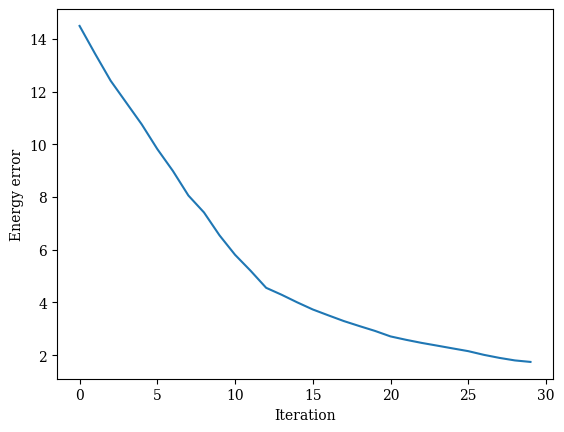

In [55]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [56]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [57]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [58]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

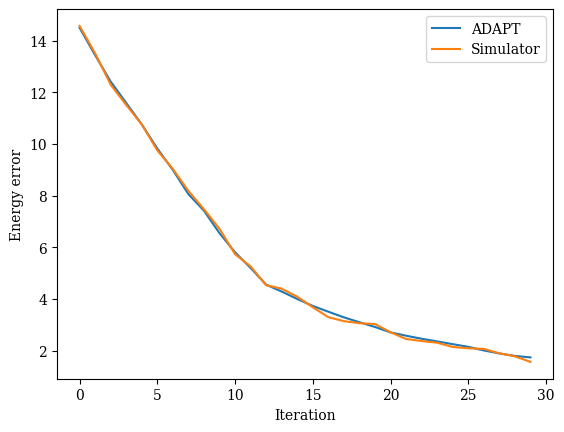

In [59]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [60]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [61]:
num_shots = 100_000
sampler = Sampler(sim)

In [62]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sim.run(to_run)
    # counts = job.result().data()['counts']
    # bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    # counts1 = bit_array.get_counts()
    job = sampler.run((circuit,), shots=num_shots)
    data = job.result()[0].data
    bit_array = data['meas']
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'x': 9, 'rx': 2, 'h': 2, 'cx': 2, 'barrier': 2, 'rz': 1})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'x': 9, 'rx': 4, 'h': 4, 'cx': 4, 'barrier': 3, 'rz': 2})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'x': 9, 'rx': 6, 'h': 6, 'cx': 6, 'barrier': 4, 'rz': 3})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'x': 9, 'rx': 8, 'h': 8, 'cx': 8, 'barrier': 5, 'rz': 4})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'rx': 10, 'h': 10, 'cx': 10, 'x': 9, 'barrier': 6, 'rz': 5})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'rx': 12, 'h': 12, 'cx': 12, 'x': 9, 'barrier': 7, 'rz': 6})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'rx': 14, 'h': 14, 'cx': 14, 'x': 9, 'barrier': 8, 'rz': 7})
On circuit 7/30
Gate counts (w/ pre-ini

In [63]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

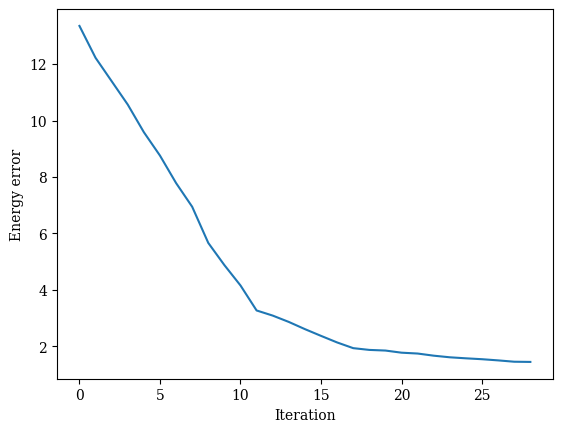

In [64]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [65]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

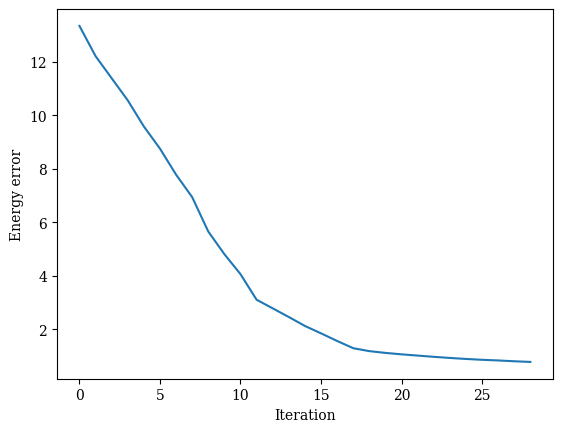

In [66]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

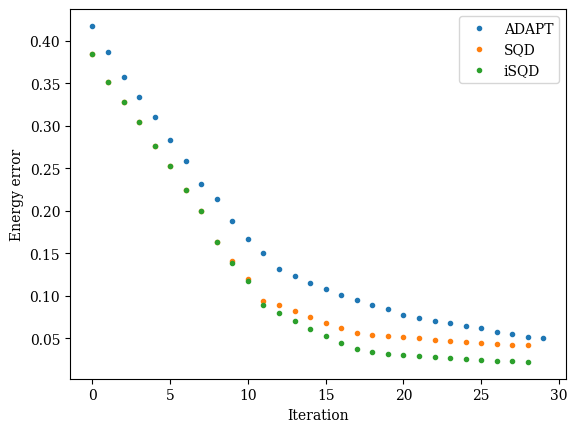

In [67]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()

## How many did we keep?

In [70]:
num_kept = []
total_shots = []
for bit_array in bit_arrays:
    bit_matrix = bit_array.to_bool_array()
    original_size = bit_matrix.shape[0]
    bit_matrix = sort_and_remove_duplicates(bit_matrix)
    new_size = bit_matrix.shape[0]
    num_kept.append(new_size)
    total_shots.append(original_size)

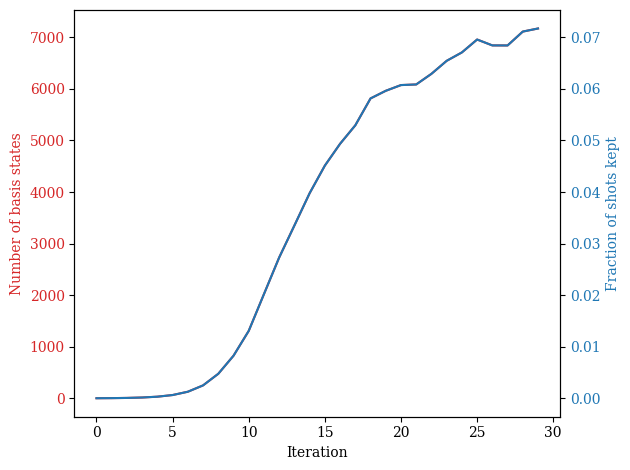

In [76]:
ratio_kept = np.array(num_kept) / np.array(total_shots)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Number of basis states', color=color)
ax1.plot(num_kept, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fraction of shots kept', color=color)  # we already handled the x-label with ax1
ax2.plot(ratio_kept, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()